In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# PSD code
from scipy import signal
from scipy import interpolate
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

def rms(data):
    return np.sqrt(np.sum(np.square(data))/len(data))

def sn_map(data, mask):
    data_sn = copy.copy(data)
    data_sn[mask==0] = np.nan
    return data_sn

In [9]:
fol_loc = 'OAP_coated/'
ca = 75
opt_name = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
surf_unit = u.micron # units in the file
tot_opt = len(opt_name)
dx_set = np.zeros(tot_opt)
max_set = np.zeros(tot_opt)
min_set = np.zeros(tot_opt)
rms_set = np.zeros(tot_opt)

surf = []
mask = []

for jopt in range(0, len(opt_name)):
    filename = '{0}/oap{1}_{2}CA_'.format(fol_loc, opt_name[jopt], ca)
    hdu = fits.open(filename+'surf.fits')[0]
    # for local in-loop data collecting
    surf_data = (hdu.data*surf_unit).to(u.nm)
    mask_data = fits.open(filename+'mask.fits')[0].data
    active_data = surf_data[mask_data==1].value
    # for full notebook data access
    surf.append(surf_data)
    mask.append(mask_data)
    dx_set[jopt] = hdu.header['latres']
    max_set[jopt] = np.amax(active_data)
    min_set[jopt] = np.amin(active_data)
    rms_set[jopt] = rms(active_data)

In [10]:
rms_set

array([20.12280149, 22.40053683, 22.1452491 , 20.70039767, 25.66158384,
       24.852191  , 26.79534388, 26.2294461 ])

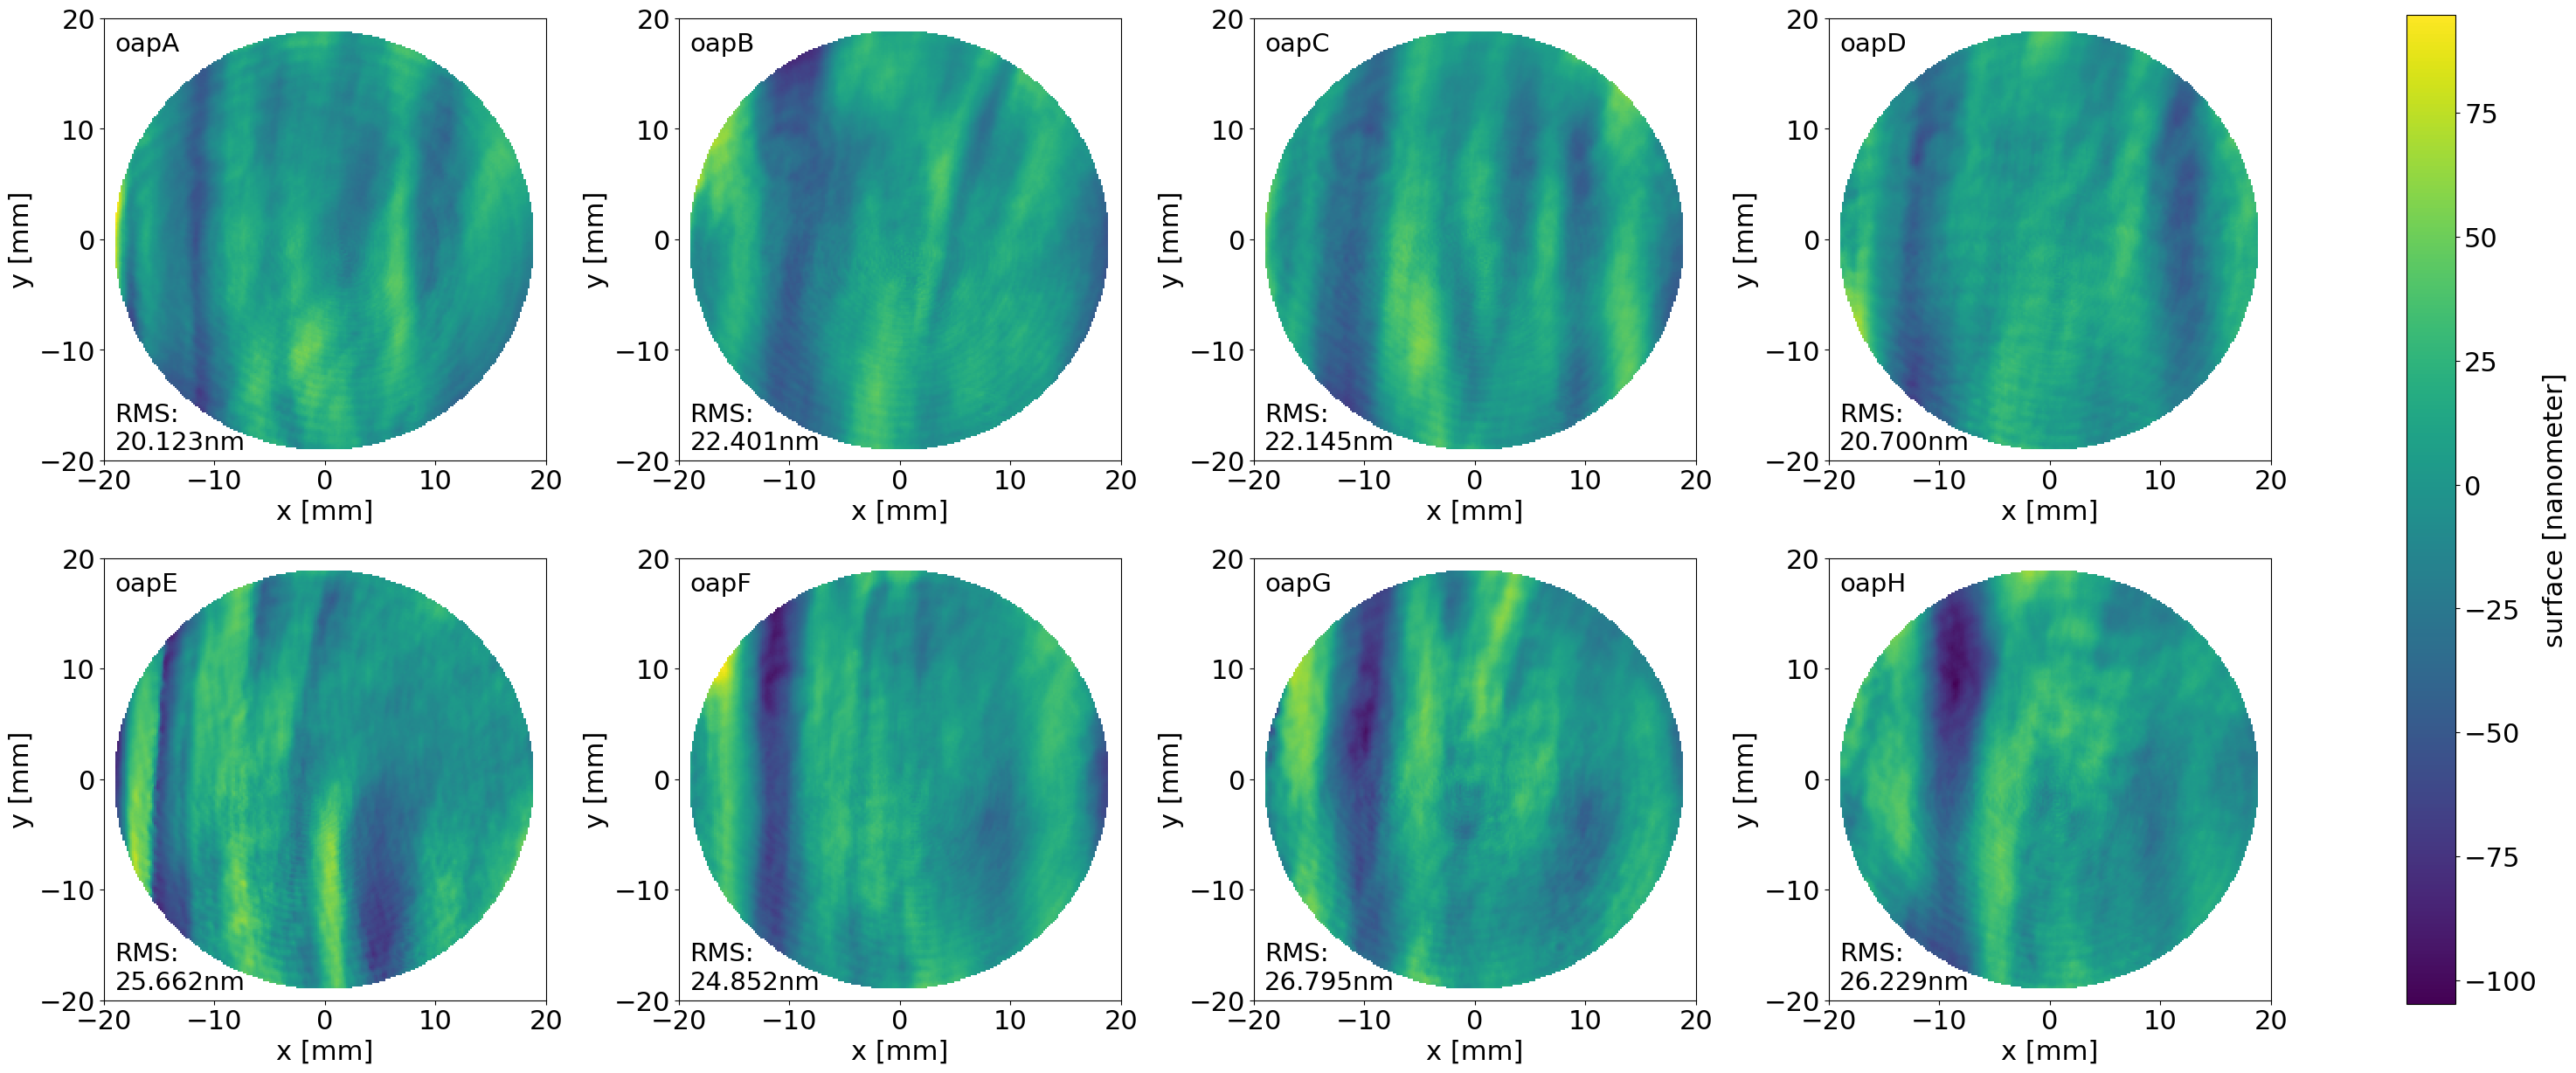

In [24]:
# set the axis scaling
vmin = np.amin(min_set)
vmax = np.amax(max_set)

text_pos_name = (-19, 17)
text_pos_rms = (-19, -19)

matplotlib.rcParams["font.size"]=22
fig, axes = plt.subplots(nrows=2, ncols=4, dpi=100, facecolor='white',
                         figsize=(40,15))#, dpi=100)
fig.subplots_adjust(wspace=0.3)

n=0
for ax in axes.flat:
    # nan mask the data
    sn_data = sn_map(surf[n], mask[n])
    # set up the data range
    box = int(surf[n].shape[0]/2)
    rk = np.linspace(-box, box, (box*2), endpoint=False)
    rks = (rk*dx_set[n]*1e3*u.mm) # dx_set is in meters
    rks_extent = [np.amin(rks).value, np.amax(rks).value, 
                  np.amin(rks).value, np.amax(rks).value]
    im = ax.imshow(sn_data, origin='lower',
                   extent=rks_extent, vmin=vmin, vmax=vmax)
    ax.set_xticks([-20, -10, 0, 10, 20])
    ax.set_yticks([-20, -10, 0, 10, 20])
    ax.set_xlabel('x [{0}]'.format(str(rks.unit)))
    ax.set_ylabel('y [{0}]'.format(str(rks.unit)))
    oap_name = 'oap{0}'.format(opt_name[n])
    ax.text(text_pos_name[0], text_pos_name[1], oap_name, 
            fontsize=21, color='black')
    ax.text(text_pos_rms[0], text_pos_rms[1], 'RMS:\n{0:.3f}nm'.format(rms_set[n]), 
            fontsize=21, color='black')
    
    n += 1
    
fig.colorbar(im, ax=axes.ravel().tolist()).set_label('surface [{0}]'.format('nanometer'))
plt.show()

In [25]:
np.mean(rms_set)

23.613443739375477

In [26]:
np.std(rms_set)

2.423697818190414